In [33]:
import numpy as np
import epde.interface.interface as epde_alg
import torch
from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens, ExternalDerivativesTokens, TrigonometricTokens
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

import matplotlib as mpl
mpl.rc('text', usetex=False)

In [35]:
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda")

2.4.0
True


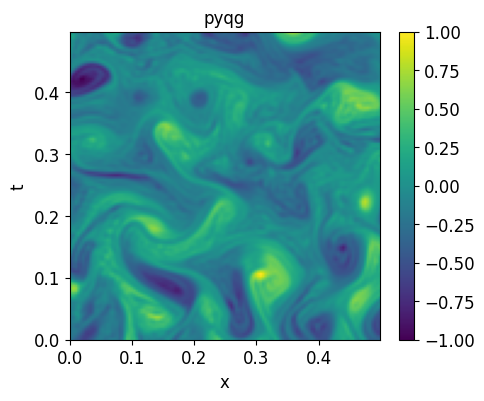

In [36]:
#pyqg          
data = np.load('data_pyqg_noise0.npy')         
grid_x = np.load('x_pyqg_noise0.npy')
grid_y = np.load('y_pyqg_noise0.npy')
x = grid_x
y = grid_y
deriv_x = np.load('pyqg_Gradient_x_noise0.npy')
deriv_xx = np.load('pyqg_Gradient_xx_noise0.npy')
deriv_y = np.load('pyqg_Gradient_y_noise0.npy')
deriv_yy = np.load('pyqg_Gradient_yy_noise0.npy')

boundary = 5
dimensionality = data.ndim - 1   
grids = np.meshgrid(y, x, indexing = 'ij')    

plt.figure(figsize=(5, 4))
plt.imshow(data, aspect='auto', extent=[np.min(x), np.max(x),np.min(y), np.max(y)], cmap='viridis')
plt.colorbar()
plt.title('pyqg')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [37]:
multiobjective_mode = True
epde_search_obj = epde_alg.EpdeSearch(multiobjective_mode=multiobjective_mode, use_solver = False, 
                                        dimensionality = dimensionality, boundary = 5,
                                        coordinate_tensors = grids)

popsize = 7
if multiobjective_mode:
    epde_search_obj.set_moeadd_params(population_size = popsize, 
                                        training_epochs=60)
else:
    epde_search_obj.set_singleobjective_params(population_size = popsize, 
                                                training_epochs=60)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x0000028C70F43440>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x0000028C70F43440>


In [38]:
print(grids[0].shape)
print(grids[1].shape)
print(deriv_x.shape)
print(data.shape)

(128, 128)
(128, 128)
(128, 128)
(128, 128)


In [39]:
custom_grid_tokens = CacheStoredTokens(token_type = 'grid',                                     
                                       token_labels = ['x', 'y'],
                                        token_tensors={'x' : grids[0], 'y' : grids[1]},
                                        params_ranges = {'power' : (1, 1)},
                                        params_equality_ranges = None)

trig_tokens = TrigonometricTokens(dimensionality = dimensionality)

trig_token_params: VALUES = (0, 1)


In [40]:
#pyqg
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.5, 0.5]}

#derivs = np.stack((deriv_y.reshape(-1),
#                   deriv_yy.reshape(-1),
#                   deriv_x.reshape(-1),
#                   deriv_xx.reshape(-1)), axis=1)
derivs = np.stack((deriv_y.reshape(-1),
                   deriv_x.reshape(-1)), axis=1)

print('data.shape =', torch.tensor(data).shape)
print('derivs.shape = ', torch.tensor(derivs).shape)
opt_val = 1e-4
bounds = (1e-10, 1e-1) if multiobjective_mode else (opt_val, opt_val) 

results = []

for i in range(1):
    epde_search_obj.fit(data=data, variable_names=['u',], max_deriv_order=(1, 1), derivs = [derivs,],
                        equation_terms_max_number=5, data_fun_pow=1, 
                        additional_tokens=[trig_tokens, custom_grid_tokens],
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=bounds)
    text_eq = epde_search_obj.equations(only_print=False, only_str=True, num=1)
    results.extend(text_eq)  
results = list(itertools.chain.from_iterable(results))
print(results)


data.shape = torch.Size([128, 128])
derivs.shape =  torch.Size([16384, 2])
Deriv orders after definition [[None], [0], [1]]
initial_shape (128, 128) derivs_tensor.shape (16384, 2)
self.tokens is ['u', 'du/dx0', 'du/dx1']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'du/dx1': [1]}
The cardinality of defined token pool is [3 2 2]
Among them, the pool contains [3]
Creating new equation, sparsity value [0.00021141]
New solution accepted, confirmed 1/7 solutions.
Creating new equation, sparsity value [1.91253472e-06]
New solution accepted, confirmed 2/7 solutions.
Creating new equation, sparsity value [7.60311e-08]
New solution accepted, confirmed 3/7 solutions.
Creating new equation, sparsity value [1.85205971e-06]
New solution accepted, confirmed 4/7 solutions.
Creating new equation, sparsity value [0.0008969]
New solution accepted, confirmed 5/7 solutions.
Creating new equation, sparsity value [3.20991169e-05]
New solution accepted, confirmed 6/7 solutions.
Creating new equation, s

In [41]:
results


["0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 5.449769446702334, dim: 1.0} + 0.5456775651932823 * du/dx1{power: 1.0} * sin{power: 1.0, freq: 2.0146907498739934, dim: 0.0} + -0.0008651629179821206 = du/dx1{power: 1.0} * x{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.004996596829699375}}",
 "-0.317259710119593 * du/dx0{power: 1.0} + 0.2945504530950895 * du/dx0{power: 1.0} * cos{power: 1.0, freq: 3.6793119049072502, dim: 1.0} + 2.6586963459207062 * du/dx0{power: 1.0} * y{power: 1.0} + 0.0008101102568039203 * du/dx1{power: 1.0} * cos{power: 1.0, freq: 4.124494058239632, dim: 0.0} + 0.000544588457575896 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.2243750012882675, dim: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_ter

In [42]:
#переносим все в левую часть и сохраняем в таком виде
def transform_equation(equation):
    left_side, right_side = equation.split('=')
    left_side = left_side.strip()
    right_side = right_side.strip().split('\n')[0]  
    new_term = f"-1.0 * {right_side}"
    left_side_parts = left_side.split('+')
    left_side_parts = [part.strip() for part in left_side_parts]
    last_term = left_side_parts[-1]
    
    left_side_parts.insert(-1, new_term) 
    
    final_left_side = ' + '.join(left_side_parts)
    final_equation = f"{final_left_side} = 0.0\n{equation.split('\n', 1)[-1]}"
    
    return final_equation

transformed_results = [transform_equation(eq) for eq in results]

for transformed in transformed_results:
    print(transformed)

0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 5.449769446702334, dim: 1.0} + 0.5456775651932823 * du/dx1{power: 1.0} * sin{power: 1.0, freq: 2.0146907498739934, dim: 0.0} + -1.0 * du/dx1{power: 1.0} * x{power: 1.0} + -0.0008651629179821206 = 0.0
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.004996596829699375}}
-0.317259710119593 * du/dx0{power: 1.0} + 0.2945504530950895 * du/dx0{power: 1.0} * cos{power: 1.0, freq: 3.6793119049072502, dim: 1.0} + 2.6586963459207062 * du/dx0{power: 1.0} * y{power: 1.0} + 0.0008101102568039203 * du/dx1{power: 1.0} * cos{power: 1.0, freq: 4.124494058239632, dim: 0.0} + -1.0 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.2243750012882675, dim: 1.0} + 0.000544588457575896 = 0.0
{'terms_number': {'optimizable': False, 'value': 5}, '

In [43]:
results = transformed_results

In [44]:
#преобразование из научной нотации в обычную
def convert_scientific_to_decimal(expression):

    sci_notation_regex = re.compile(r'([-+]?\d*\.\d+|\d+\.?\d*)e([-+]?\d+)')
    def replace_match(match):
        base = float(match.group(0))  # Преобразование в число с плавающей точкой
        return "{:f}".format(base)    # Форматирование в обычную нотацию

    return sci_notation_regex.sub(replace_match, expression)

converted_results = [convert_scientific_to_decimal(eq) for eq in results]
print(converted_results)



["0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 5.449769446702334, dim: 1.0} + 0.5456775651932823 * du/dx1{power: 1.0} * sin{power: 1.0, freq: 2.0146907498739934, dim: 0.0} + -1.0 * du/dx1{power: 1.0} * x{power: 1.0} + -0.0008651629179821206 = 0.0\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.004996596829699375}}", "-0.317259710119593 * du/dx0{power: 1.0} + 0.2945504530950895 * du/dx0{power: 1.0} * cos{power: 1.0, freq: 3.6793119049072502, dim: 1.0} + 2.6586963459207062 * du/dx0{power: 1.0} * y{power: 1.0} + 0.0008101102568039203 * du/dx1{power: 1.0} * cos{power: 1.0, freq: 4.124494058239632, dim: 0.0} + -1.0 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.2243750012882675, dim: 1.0} + 0.000544588457575896 = 0.0\n{'terms_number': {'optimizable': False, 'value'

In [45]:
results = converted_results
results

["0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * cos{power: 1.0, freq: 5.449769446702334, dim: 1.0} + 0.5456775651932823 * du/dx1{power: 1.0} * sin{power: 1.0, freq: 2.0146907498739934, dim: 0.0} + -1.0 * du/dx1{power: 1.0} * x{power: 1.0} + -0.0008651629179821206 = 0.0\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.004996596829699375}}",
 "-0.317259710119593 * du/dx0{power: 1.0} + 0.2945504530950895 * du/dx0{power: 1.0} * cos{power: 1.0, freq: 3.6793119049072502, dim: 1.0} + 2.6586963459207062 * du/dx0{power: 1.0} * y{power: 1.0} + 0.0008101102568039203 * du/dx1{power: 1.0} * cos{power: 1.0, freq: 4.124494058239632, dim: 0.0} + -1.0 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.2243750012882675, dim: 1.0} + 0.000544588457575896 = 0.0\n{'terms_number': {'optimizable': False, 'value

In [27]:
np.save('results_pyqg_Gradient_noise0.npy', results)


In [28]:
#определяем какие слагаемые чаще всего встречаются
results_list = []

pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* d\^2u/dx1\^2\{power: 1\.0\} \+"
pattern_d2u_dx0_2 = r"(-?\d+\.\d+) \* d\^2u/dx0\^2\{power: 1\.0\} \+"
pattern_du_dx0 = r"(-?\d+\.\d+) \* du/dx0\{power: 1\.0\} \+"
pattern_du_dx1 = r"(-?\d+\.\d+) \* du/dx1\{power: 1\.0\} \+"
pattern_u = r"(-?\d+\.\d+) \* u\{power: 1\.0\} \+"
pattern_du_dx1_x = r"(-?\d+\.\d+)\s\*\s(?:x\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+|du/dx1\{power: 1\.0\} \* x\{power: 1\.0\} \+)"
pattern_du_dx1_u = r"(-?\d+\.\d+)\s\*\s(?:u\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+|du/dx1\{power: 1\.0\} \* u\{power: 1\.0\} \+)"
pattern_du_dx0_u = r"(-?\d+\.\d+)\s\*\s(?:u\{power: 1\.0\} \* du/dx0\{power: 1\.0\} \+|du/dx0\{power: 1\.0\} \* u\{power: 1\.0\} \+)"
pattern_du_dx1_y = r"(-?\d+\.\d+)\s\*\s(?:y\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+|du/dx1\{power: 1\.0\} \* y\{power: 1\.0\} \+)"
pattern_du_dx0_x = r"(-?\d+\.\d+)\s\*\s(?:x\{power: 1\.0\} \* du/dx0\{power: 1\.0\} \+|du/dx0\{power: 1\.0\} \* x\{power: 1\.0\} \+)"
pattern_du_dx0_u = r"(-?\d+\.\d+)\s\*\s(?:u\{power: 1\.0\} \* du/dx0\{power: 1\.0\} \+|du/dx0\{power: 1\.0\} \* u\{power: 1\.0\} \+)"
pattern_d2u_dx0_2_x = r"(-?\d+\.\d+)\s\*\s(?:d\^2u/dx0\^2\{power: 1\.0\} \* x\{power: 1\.0\} \+|x\{power: 1\.0\} \* d\^2u/dx0\^2\{power: 1\.0\} \+)"
pattern_d2u_dx1_2_x = r"(-?\d+\.\d+)\s\*\s(?:d\^2u/dx1\^2\{power: 1\.0\} \* x\{power: 1\.0\} \+|x\{power: 1\.0\} \* d\^2u/dx1\^2\{power: 1\.0\} \+)"
pattern_du_dx0_du_dx1 = r"(-?\d+\.\d+)\s\*\s(?:du/dx0\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+|du/dx1\{power: 1\.0\} \* du/dx0\{power: 1\.0\} \+)"
pattern_du_dx1_d2u_dx0_2 = r"(-?\d+\.\d+)\s\*\s(?:du/dx1\{power: 1\.0\} \* d\^2u/dx0\^2\{power: 1\.0\} \+|d\^2u/dx0\^2\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+)"
pattern_du_dx1_d2u_dx1_2 = r"(-?\d+\.\d+)\s\*\s(?:du/dx1\{power: 1\.0\} \* d\^2u/dx1\^2\{power: 1\.0\} \+|d\^2u/dx1\^2\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+)"
pattern_y_d2u_dx0_2 = r"(-?\d+\.\d+)\s\*\s(?:y\{power: 1\.0\} \* d\^2u/dx0\^2\{power: 1\.0\} \+|d\^2u/dx0\^2\{power: 1\.0\} \* y\{power: 1\.0\} \+)"
pattern_d2u_dx1_2_u = r"(-?\d+\.\d+)\s\*\s(?:d\^2u/dx1\^2\{power: 1\.0\} \* u\{power: 1\.0\} \+|u\{power: 1\.0\} \* d\^2u/dx1\^2\{power: 1\.0\} \+)"
pattern_d2u_dx0_2_u = r"(-?\d+\.\d+)\s\*\s(?:d\^2u/dx0\^2\{power: 1\.0\} \* u\{power: 1\.0\} \+|u\{power: 1\.0\} \* d\^2u/dx0\^2\{power: 1\.0\} \+)"
pattern_u_x = r"(-?\d+\.\d+)\s\*\s(?:x\{power: 1\.0\} \* u\{power: 1\.0\} \+|u\{power: 1\.0\} \* x\{power: 1\.0\} \+)"
pattern_u_y = r"(-?\d+\.\d+)\s\*\s(?:y\{power: 1\.0\} \* u\{power: 1\.0\} \+|u\{power: 1\.0\} \* y\{power: 1\.0\} \+)"


pattern_free = r"([\+\-]?[0-9]*\.?[0-9]+(?:e[\+\-]?[0-9]+)?)\s*=\s*0\.0"

for eq in results:
    matches_d2u_dx1_2 = re.findall(pattern_d2u_dx1_2, eq)
    matches_d2u_dx0_2 = re.findall(pattern_d2u_dx0_2, eq)
    matches_du_dx0 = re.findall(pattern_du_dx0, eq)
    matches_du_dx1 = re.findall(pattern_du_dx1, eq)
    matches_u = re.findall(pattern_u, eq)
    matches_du_dx1_x = re.findall(pattern_du_dx1_x, eq)
    matches_du_dx1_u = re.findall(pattern_du_dx1_u, eq)
    matches_du_dx0_u = re.findall(pattern_du_dx0_u, eq)
    matches_du_dx1_y = re.findall(pattern_du_dx1_y, eq)
    matches_du_dx0_x = re.findall(pattern_du_dx0_x, eq)
    matches_du_dx0_u = re.findall(pattern_du_dx0_u, eq)
    matches_d2u_dx0_2_x = re.findall(pattern_d2u_dx0_2_x, eq)
    matches_d2u_dx1_2_x = re.findall(pattern_d2u_dx1_2_x, eq)
    matches_du_dx0_du_dx1  = re.findall(pattern_du_dx0_du_dx1, eq)
    matches_du_dx1_d2u_dx0_2  = re.findall(pattern_du_dx1_d2u_dx0_2, eq)
    matches_du_dx1_d2u_dx1_2  = re.findall(pattern_du_dx1_d2u_dx1_2, eq)
    matches_y_d2u_dx0_2  = re.findall(pattern_y_d2u_dx0_2, eq)
    matches_d2u_dx1_2_u = re.findall(pattern_d2u_dx1_2_u, eq)
    matches_d2u_dx0_2_u = re.findall(pattern_d2u_dx0_2_u, eq)
    matches_u_x = re.findall(pattern_u_x, eq)
    matches_u_y = re.findall(pattern_u_y, eq)


    match_free = re.search(pattern_free, eq)

    results_list.extend([("d^2u/dx1^2", float(coeff)) for coeff in matches_d2u_dx1_2 if float(coeff) != 0])
    results_list.extend([("d^2u/dx0^2", float(coeff)) for coeff in matches_d2u_dx0_2 if float(coeff) != 0])
    results_list.extend([("du/dx0", float(coeff)) for coeff in matches_du_dx0 if float(coeff) != 0])
    results_list.extend([("du/dx1", float(coeff)) for coeff in matches_du_dx1 if float(coeff) != 0])
    results_list.extend([("u", float(coeff)) for coeff in matches_u if float(coeff) != 0])
    results_list.extend([("du/dx1 * x", float(coeff)) for coeff in matches_du_dx1_x if float(coeff) != 0])
    results_list.extend([("du/dx1 * u", float(coeff)) for coeff in matches_du_dx1_u if float(coeff) != 0])
    results_list.extend([("du/dx0 * u", float(coeff)) for coeff in matches_du_dx0_u if float(coeff) != 0])
    results_list.extend([("du/dx1 * y", float(coeff)) for coeff in matches_du_dx1_y if float(coeff) != 0])
    results_list.extend([("du/dx0 * x", float(coeff)) for coeff in matches_du_dx0_x if float(coeff) != 0])
    results_list.extend([("du/dx0 * u", float(coeff)) for coeff in matches_du_dx0_u if float(coeff) != 0])
    results_list.extend([("d^2u/dx0^2 * x", float(coeff)) for coeff in matches_d2u_dx0_2_x if float(coeff) != 0])
    results_list.extend([("d^2u/dx1^2 * x", float(coeff)) for coeff in matches_d2u_dx1_2_x if float(coeff) != 0])
    results_list.extend([("du/dx0 * du/dx1", float(coeff)) for coeff in matches_du_dx0_du_dx1 if float(coeff) != 0])
    results_list.extend([("du/dx1 * d^2u/dx0^2", float(coeff)) for coeff in matches_du_dx1_d2u_dx0_2 if float(coeff) != 0])
    results_list.extend([("du/dx1 * d^2u/dx1^2", float(coeff)) for coeff in matches_du_dx1_d2u_dx1_2 if float(coeff) != 0])
    results_list.extend([("d^2u/dx0^2 * y", float(coeff)) for coeff in matches_y_d2u_dx0_2 if float(coeff) != 0])
    results_list.extend([("d^2u/dx1^2 * u", float(coeff)) for coeff in matches_d2u_dx1_2_u if float(coeff) != 0])
    results_list.extend([("d^2u/dx0^2 * u", float(coeff)) for coeff in matches_d2u_dx0_2_u if float(coeff) != 0])
    results_list.extend([("u * x", float(coeff)) for coeff in matches_u_x if float(coeff) != 0])
    results_list.extend([("u * y", float(coeff)) for coeff in matches_u_y if float(coeff) != 0])

'''
    if match_free:
        free_coeff = float(match_free.group(1))
        if free_coeff != 0:
            results_list.append(("free", free_coeff))
'''
df = pd.DataFrame(results_list, columns=["Term", "Coefficient"])

df = df.reset_index(drop=True)
df.to_csv('results_pyqg_Gradient_cut_noise0.csv', index=False, encoding='utf-8')

print(df)



          Term  Coefficient
0       du/dx1     0.256834
1   du/dx1 * y    -1.000000
2   du/dx0 * x     0.062533
3       du/dx0     0.015736
4       du/dx1     0.256206
5   du/dx1 * y    -1.000000
6       du/dx1     0.256834
7   du/dx1 * y    -1.000000
8   du/dx0 * x     0.062533
9       du/dx0    -0.005762
10      du/dx1     0.255907
11  du/dx1 * u    -0.034476
12  du/dx0 * u    -0.007669
13  du/dx1 * y    -1.000000
14  du/dx0 * x     0.083405
15  du/dx0 * u    -0.007669


In [29]:
#определяем какие слагаемые чаще всего встречаются 
print('колво уравнений', len(results))
data = pd.read_csv(f'results_pyqg_Gradient_cut_noise0.csv')
print(data.groupby('Term')['Coefficient'].describe())

колво уравнений 4
            count      mean       std       min       25%       50%       75%  \
Term                                                                            
du/dx0        2.0  0.004987  0.015201 -0.005762 -0.000387  0.004987  0.010362   
du/dx0 * u    2.0 -0.007669  0.000000 -0.007669 -0.007669 -0.007669 -0.007669   
du/dx0 * x    3.0  0.069490  0.012050  0.062533  0.062533  0.062533  0.072969   
du/dx1        4.0  0.256445  0.000465  0.255907  0.256131  0.256520  0.256834   
du/dx1 * u    1.0 -0.034476       NaN -0.034476 -0.034476 -0.034476 -0.034476   
du/dx1 * y    4.0 -1.000000  0.000000 -1.000000 -1.000000 -1.000000 -1.000000   

                 max  
Term                  
du/dx0      0.015736  
du/dx0 * u -0.007669  
du/dx0 * x  0.083405  
du/dx1      0.256834  
du/dx1 * u -0.034476  
du/dx1 * y -1.000000  


In [ ]:
#работаем с теми слагаемыми, которые определили как чаще встречающиеся
results_list = []

pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* d\^2u/dx1\^2\{power: 1\.0\} \+"#изменить на нужные
pattern_du_dx0 = r"(-?\d+\.\d+) \* d\^2u/dx0\^2\{power: 1\.0\} \+"
pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* d\^2u/dx1\^2\{power: 1\.0\} \+"
pattern_d2u_dx0_2 = r"(-?\d+\.\d+) \* d\^2u/dx0\^2\{power: 1\.0\} \+"

pattern_free = r"([\+\-]?[0-9]*\.?[0-9]+(?:e[\+\-]?[0-9]+)?)\s*=\s*0\.0"

for eq in results:
    matches_d2u_dx1_2 = re.findall(pattern_d2u_dx1_2, eq)
    matches_d2u_dx0_2 = re.findall(pattern_d2u_dx0_2, eq)

    match_free = re.search(pattern_free, eq)

    results_list.extend([("d^2u/dx1^2", float(coeff)) for coeff in matches_d2u_dx1_2 if float(coeff) != 0])
    results_list.extend([("d^2u/dx0^2", float(coeff)) for coeff in matches_d2u_dx0_2 if float(coeff) != 0])
'''
    if match_free:
        free_coeff = float(match_free.group(1))
        if free_coeff != 0:
            results_list.append(("free", free_coeff))
'''
df = pd.DataFrame(results_list, columns=["Term", "Coefficient"])

df = df.reset_index(drop=True)
df.to_csv('results_pyqg_Gradient_cut_noise0.csv', index=False, encoding='utf-8')

print(df)



In [ ]:
#расстояние Хэмминга, #работаем с теми слагаемыми, которые определили как чаще встречающиеся
results_list = []

pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* d\^2u/dx1\^2\{power: 1\.0\} \+"
pattern_d2u_dx0_2 = r"(-?\d+\.\d+) \* d\^2u/dx0\^2\{power: 1\.0\} \+"


for eq in results:
    matches_d2u_dx1_2 = re.findall(pattern_d2u_dx1_2, eq)
    matches_d2u_dx0_2 = re.findall(pattern_d2u_dx0_2, eq)

    count_nz_coefficients = sum(1 for match in matches_d2u_dx1_2 if float(match) != 0) + sum(1 for match in matches_d2u_dx0_2 if float(match) != 0)

    results_list.append(count_nz_coefficients)

missing = [2 - x for x in results_list]

print('колво нужных членов', results_list)
print('не хватает', missing)

def count_nonzero_coefficients(equation):
    left_side = equation.split('=')[0]
    coefficients = left_side.split('+')
    nonzero_count = sum(1 for coef in coefficients if coef.strip() and not coef.strip().startswith('00') and float(coef.split('*')[0].strip()) != 00)
    
    return nonzero_count

nonzero_coefficients_counts = [count_nonzero_coefficients(eq) - 1 for eq in results]
print('общее количество ненулевых коэффов', nonzero_coefficients_counts)

extra = [a - b for a, b in zip(nonzero_coefficients_counts, results_list)]
print('лишние', extra)

ham = [a + b for a, b in zip(extra, missing)]
print('расстояние Хэмминга', ham)
print('среднее расстояние Хэмминга', np.mean(ham))
np.save('Hamming_pyqg_Inverse_noise0.npy', ham)

def calculate_mean_and_confidence_interval(data, confidence=0.95):    
    # Вычисление среднего
    mean = np.mean(data)
    rounded_mean = round(mean)
    
    # Вычисление стандартного отклонения и размера выборки
    std_dev = np.std(data, ddof=1)  # Используем ddof=1 для выборочной оценки
    n = len(data)
    
    # Вычисление стандартной ошибки
    standard_error = std_dev / np.sqrt(n)
    
    # Вычисление доверительного интервала
    h = standard_error * stats.t.ppf((1 + confidence) / 2, n - 1)
    confidence_interval = (rounded_mean - h, rounded_mean + h)
    
    return rounded_mean, confidence_interval

mean, ci = calculate_mean_and_confidence_interval(ham)
print(f"Округленное среднее: {mean}")
print(f"Доверительный интервал: {ci}")
# Создание нового датафрейма с единственной строкой
result_df = pd.DataFrame({
    'Метод': ['Gradient'],
    'Среднее': [mean],
    'Доверительный интервал': [ci],
})

print(result_df)
result_df.to_csv('Ham_pyqg_Gradient_noise0.csv', index=False, encoding='utf-8')


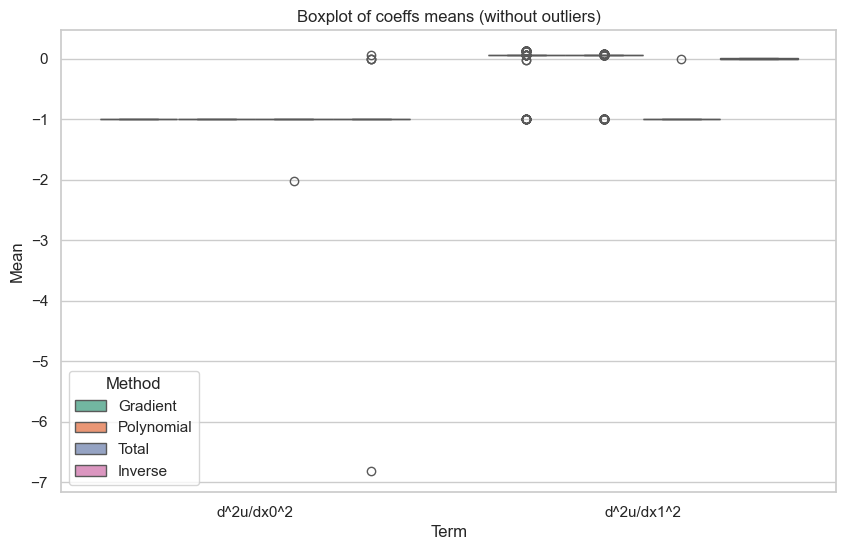

In [194]:
#noise = 0
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral','Total','Inverse']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_pyqg_{method}_cut_noise0.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)

# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=all_data, palette="Set2", dodge=True)

plt.title('Boxplot of coeffs means (without outliers)')
plt.xlabel('Term')
plt.ylabel('Mean')
plt.legend(title='Method')
plt.show()


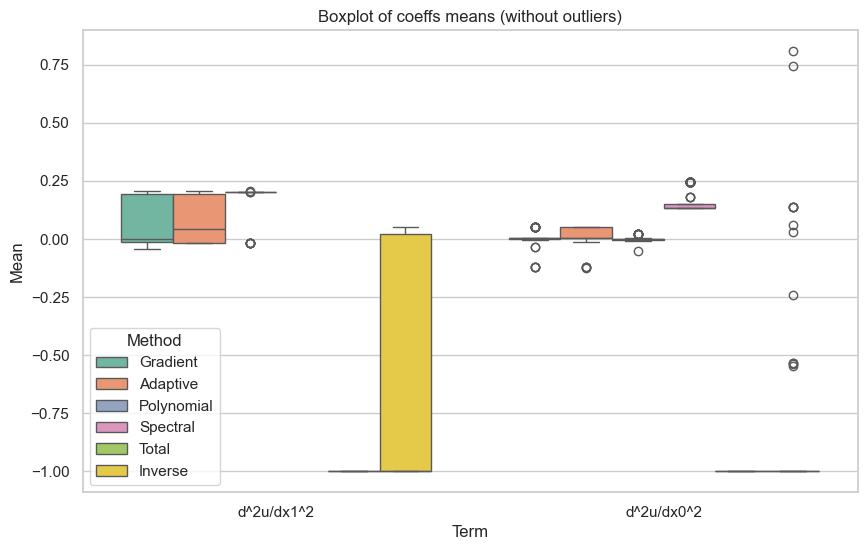

In [195]:
#noise = 0.005
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral', 'Total','Inverse']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_wave_{method}_cut_noise0.005.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)

# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=all_data, palette="Set2", dodge=True)

plt.title('Boxplot of coeffs means (without outliers)')
plt.xlabel('Term')
plt.ylabel('Mean')
plt.legend(title='Method')
plt.show()


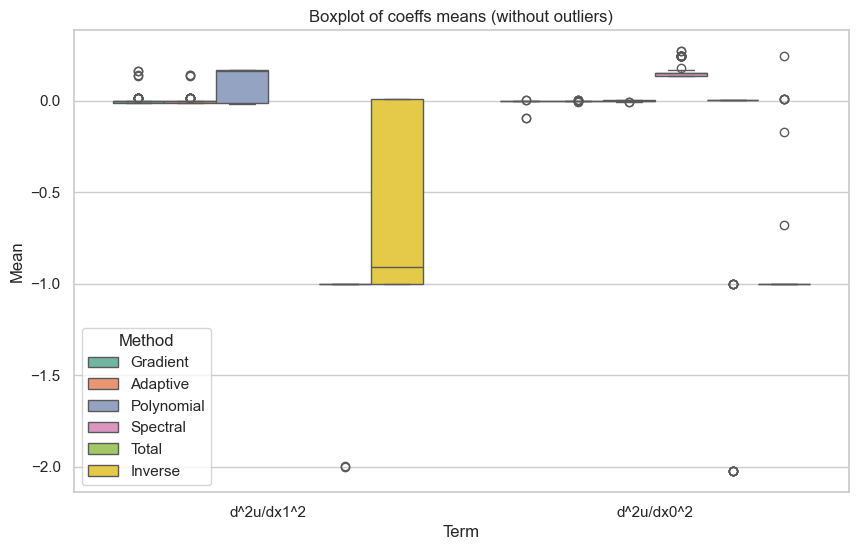

In [196]:
#noise = 0.01
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral', 'Total','Inverse']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_wave_{method}_cut_noise0.01.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)

# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=all_data, palette="Set2", dodge=True)

plt.title('Boxplot of coeffs means (without outliers)')
plt.xlabel('Term')
plt.ylabel('Mean')
plt.legend(title='Method')
plt.show()


In [60]:
print(all_data.groupby('Term')['Coefficient'].describe())

            count      mean       std       min       25%       50%       75%  \
Term                                                                            
d^2u/dx0^2  867.0 -1.003217  0.212416 -6.822924 -1.000000 -1.000000 -1.000000   
d^2u/dx1^2  648.0 -0.195241  0.461487 -1.000000 -0.004179  0.062651  0.062672   

                 max  
Term                  
d^2u/dx0^2  0.064601  
d^2u/dx1^2  0.125208  


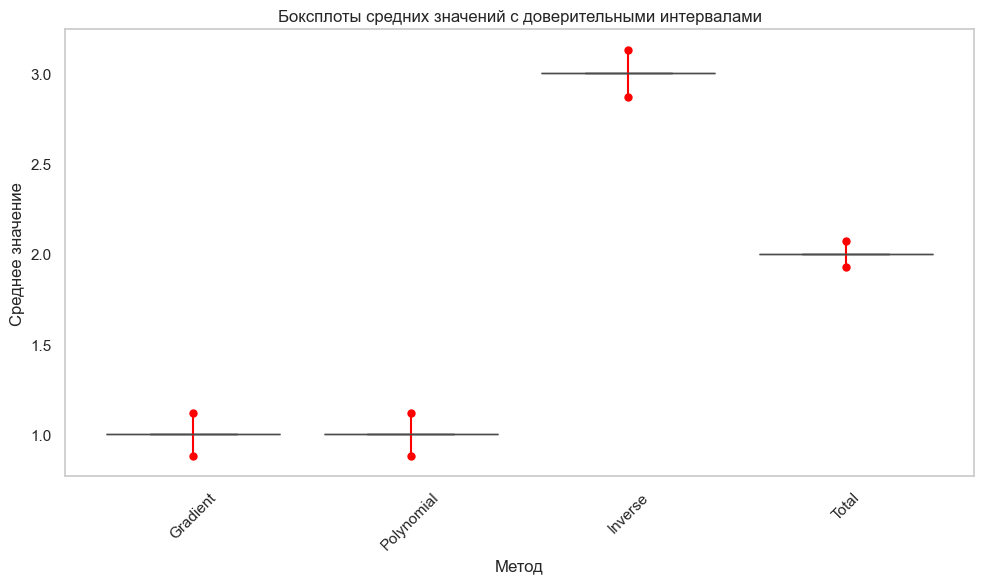

In [197]:
#noise = 0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_pyqg_Gradient_noise0.csv')
data2 = pd.read_csv('Ham_pyqg_Adaptive_noise0.csv')
data3 = pd.read_csv('Ham_pyqg_Polynomial_noise0.csv')
data4 = pd.read_csv('Ham_pyqg_Spectral_noise0.csv')
data5 = pd.read_csv('Ham_pyqg_Inverse_noise0.csv')
data6 = pd.read_csv('Ham_pyqg_Total_noise0.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1, data2, data3, data4, data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')

plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


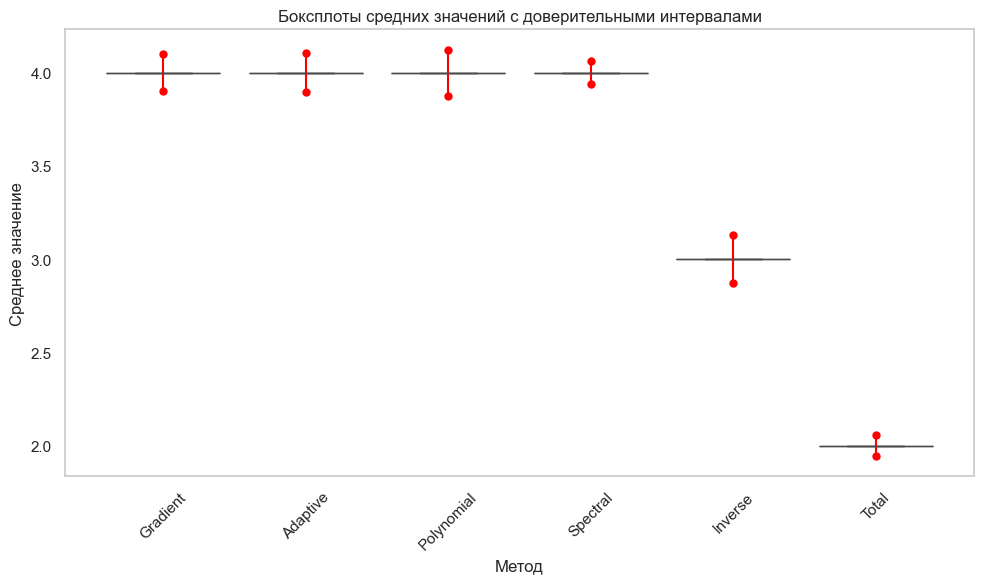

In [198]:
#noise = 0.005
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_pyqg_Gradient_noise0.005.csv')
data2 = pd.read_csv('Ham_pyqg_Adaptive_noise0.005.csv')
data3 = pd.read_csv('Ham_pyqg_Polynomial_noise0.005.csv')
data4 = pd.read_csv('Ham_pyqg_Spectral_noise0.005.csv')
data5 = pd.read_csv('Ham_pyqg_Inverse_noise0.005.csv')
data6 = pd.read_csv('Ham_pyqg_Total_noise0.005.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1,data2,data3,data4,data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')

plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


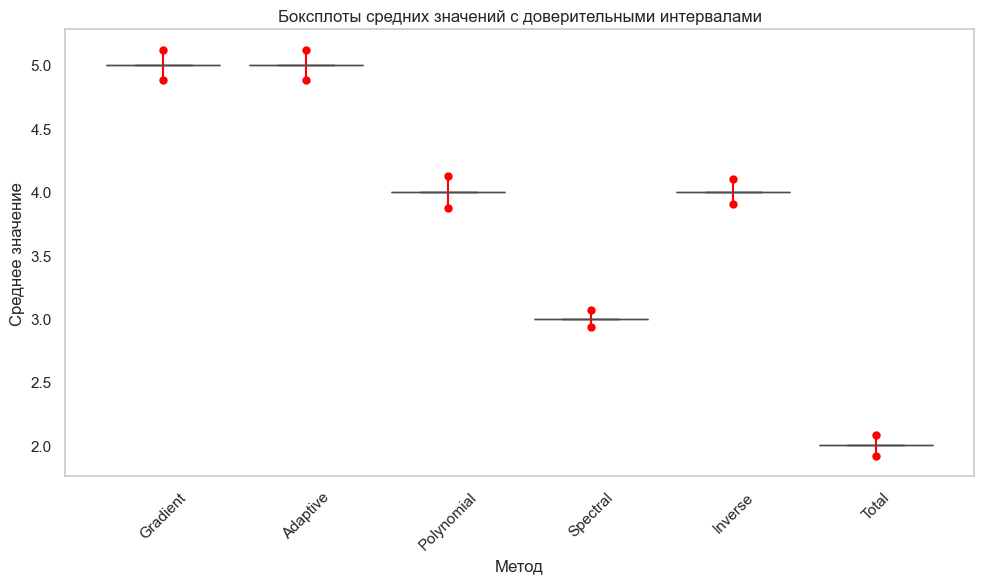

In [199]:
#noise = 0.01
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_pyqg_Gradient_noise0.01.csv')
data2 = pd.read_csv('Ham_pyqg_Adaptive_noise0.01.csv')
data3 = pd.read_csv('Ham_pyqg_Polynomial_noise0.01.csv')
data4 = pd.read_csv('Ham_pyqg_Spectral_noise0.01.csv')
data5 = pd.read_csv('Ham_pyqg_Inverse_noise0.01.csv')
data6 = pd.read_csv('Ham_pyqg_Total_noise0.01.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1,data2,data3,data4,data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')

plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


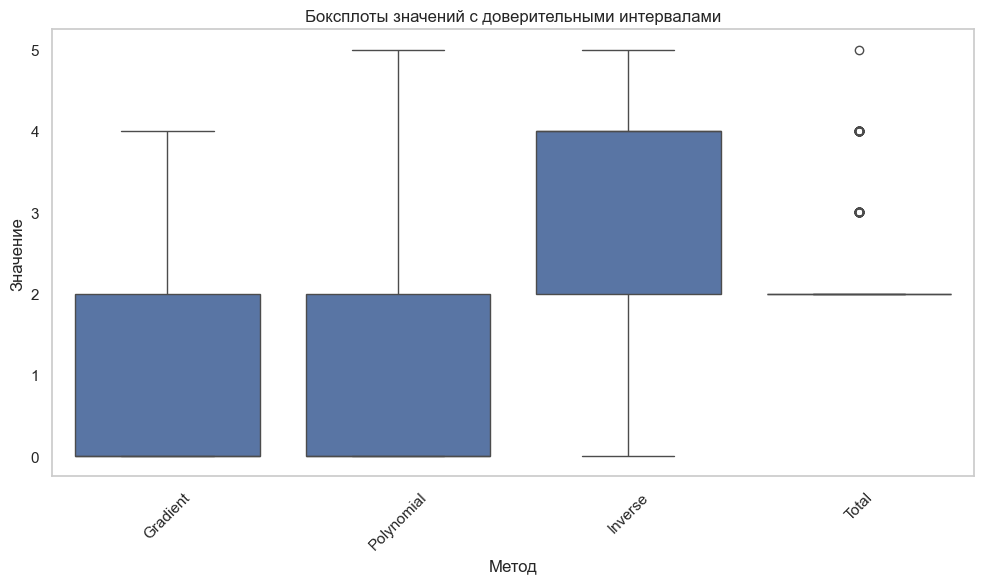

In [200]:
#noise = 0

data_gradient = np.load('Hamming_pyqg_Gradient_noise0.npy')
data_adaptive = np.load('Hamming_pyqg_Adaptive_noise0.npy')
data_polynomial = np.load('Hamming_pyqg_Polynomial_noise0.npy')
data_spectral = np.load('Hamming_pyqg_Spectral_noise0.npy')
data_inverse = np.load('Hamming_pyqg_Inverse_noise0.npy')
data_total = np.load('Hamming_pyqg_Total_noise0.npy')



df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Боксплоты значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


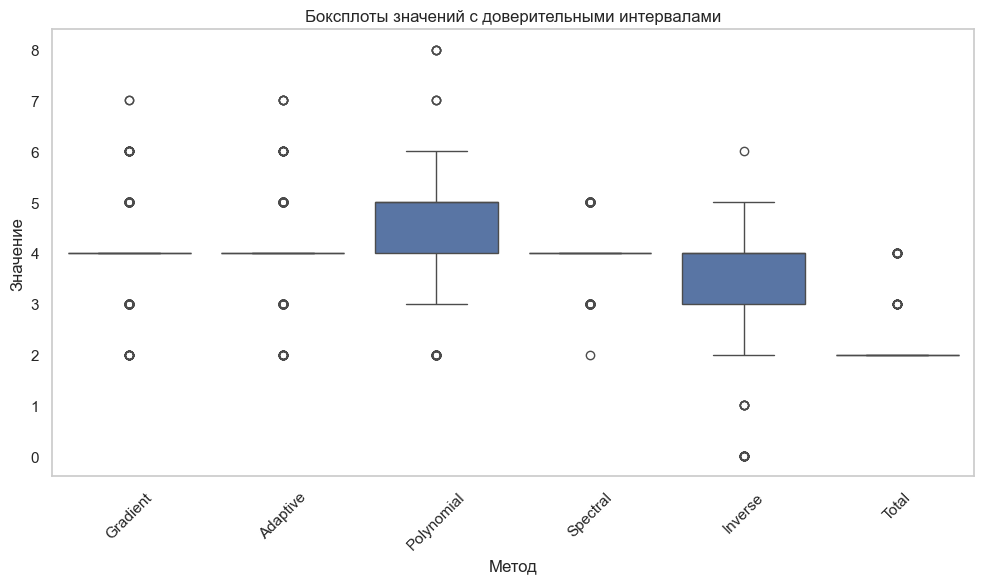

In [202]:
#noise = 0.005

data_gradient = np.load('Hamming_pyqg_Gradient_noise0.005.npy')
data_adaptive = np.load('Hamming_pyqg_Adaptive_noise0.005.npy')
data_polynomial = np.load('Hamming_pyqg_Polynomial_noise0.005.npy')
data_spectral = np.load('Hamming_pyqg_Spectral_noise0.005.npy')
data_inverse = np.load('Hamming_pyqg_Inverse_noise0.005.npy')
data_total = np.load('Hamming_pyqg_Total_noise0.005.npy')


df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Боксплоты значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


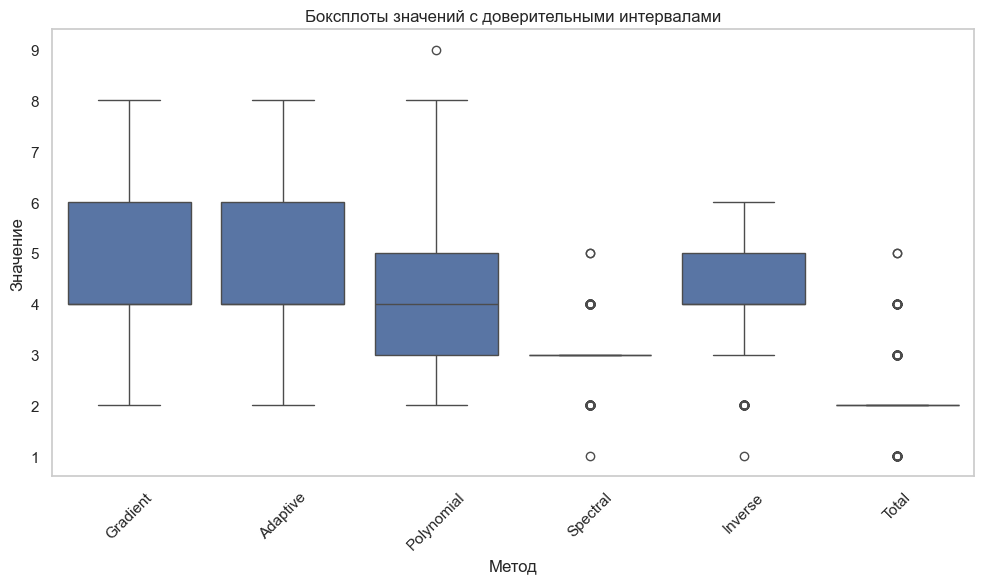

In [203]:
#noise = 0.01

data_gradient = np.load('Hamming_pyqg_Gradient_noise0.01.npy')
data_adaptive = np.load('Hamming_pyqg_Adaptive_noise0.01.npy')
data_polynomial = np.load('Hamming_pyqg_Polynomial_noise0.01.npy')
data_spectral = np.load('Hamming_pyqg_Spectral_noise0.01.npy')
data_inverse = np.load('Hamming_pyqg_Inverse_noise0.01.npy')
data_total = np.load('Hamming_pyqg_Total_noise0.01.npy')


df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Боксплоты значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
